# Nonlinear Least Squares curve fitting
Trying to put together a minimal implementation of the Levenberg-Marquardt algorithm for nonlinear least squares curve fitting.
This is mostly for my own learning, but it was also requested on [my blog](https://workyourtech.com/2020/04/05/fitting-curves-to-data-with-an-arduino/#comment-28)

## Following these papers: [this](http://people.duke.edu/~hpgavin/ce281/lm.pdf) and [this](https://www.eecs189.org/static/notes/n12.pdf)

# Nomenclature
 - x - x-values (probably time)
 - f(x) - function we're modelling the data as, this takes parameters p
 - y - f(x) data we're fitting the function to
 - p - parameters
 
- λ - LM factor that weights for either Gauss-Newton at high values, or Grad descent for low values

In [1]:
using Plots
using LinearAlgebra # For I

## Chi square measure of goodness of fit (used for λ measure in LM algo)

In [2]:
function chisquare(O, E)
    return sum(((O .- E).^2) ./ E)
end

chisquare (generic function with 1 method)

## Parameter delta helper for Jacobian calculator (Forward differences)
The nicest way I've found to calculate the jacobian matrix is by generating a square matrix with each parameter perturbation in a row like this, then map each row of the perturbation matrix to get mxn matrix

In [3]:
function perturbparameters(parameters, perturbation)
    return parameters .* (ones(length(parameters), length(parameters)) + perturbation * I)
end
perturbparameters([1, 2, 3], 0.001)

3×3 Array{Float64,2}:
 1.001  1.0    1.0
 2.0    2.002  2.0
 3.0    3.0    3.003

## Jacobian function
The functions we're working with here take a vector of datapoints of **m** length and return a vector of the function applied to each of those datapoints.

The function takes **n** parameters.

The jacobian is an **m**x**n** matrix that gives the gradient of each parameter if all the others are fixed, for all **n** datapoints.

In [4]:
function jacobian(f, x::Vector{Float64}, parameters, perturbation=0.0001)::Array{Float64, 2}
    return cat(
        map(row -> (f(x, row...) - f(x, parameters...)) / perturbation,
            eachrow(perturbparameters(parameters, perturbation)))...,
        dims=2)
end

jacobian (generic function with 2 methods)

## Meat of the algo, two different update functions, gradient descent and gauss-newton

In [74]:
function gradient(y, ŷ, J, W=I)
    return transpose(J)*W*(y-ŷ)
end

function gaussnewton(y, ŷ, J, W=I)
    return inv(transpose(J)*W*J)*transpose(J)*W*(y-ŷ)
end

function lm(y, ŷ, J, λ, W=I)
    grad = transpose(J)*W*(y-ŷ)
    second = transpose(J)*W*J + λ*Diagonal(transpose(J)*W*J)
    return  inv(second) * grad
end

# symbol ρᵢ in first paper, this is compared to a user-given measure ϵ
function lmmetric(f, x, y, p, h, λ, J, W=I)
    yold = f(x, p...)
    ynew = f(x, (p .+ h)...)
    return (chisquare(y, yold) - chisquare(y, ynew)) /
        (transpose(h) * (λ * Diagonal(transpose(J)*W*J) * h + transpose(J)*W*(y-yold)))
end

# Todo: Use Broyden rank-1 update for updating jacobian in certain conditions
# http://people.duke.edu/~hpgavin/ce281/lm.pdf
# https://www.eecs189.org/static/notes/n12.pdf

function step(f, x::Vector{Float64}, y::Vector{Float64}, parameters;
        ϵ=1e-2, loss=(y, ŷ)->(sum((y-ŷ).^2)), lossvalues=[], ρvalues=[], λvalues=[])
    p = copy(parameters)
    
    λfactordown = 9
    λfactorup = 11
    λ = 1e-2
    
    iterations = 1
    # Initialise so we can access it after while loop
    lossvalue = 2
    while true
        ŷ = f(x, p...)
        J = jacobian(f, x, parameters)
        
        h = lm(y, ŷ, J, λ)
        ρ =lmmetric(f, x, y, parameters, h, λ, J)

        if ρ > ϵ
            p = p + h
            λ = max(λ / λfactordown, 10^7)
        else
            λ = min(λ * λfactorup, 10^7)
        end
        
        lossvalue = loss(y, ŷ)
        push!(lossvalues, lossvalue)
        push!(ρvalues, ρ)
        push!(λvalues, λ)
        #println("Experiment $(iterations): parameters $(p) loss $(sumsquares)")
        lossvalue > 1 || break
        iterations = iterations + 1
        iterations > 5000 && break
    end
    print("Iterations: $(iterations), Loss: $(lossvalue)")
    return p
end

step (generic function with 2 methods)

In [75]:
α = 0.01
f(x, a, b, c, d, e) = a.+b.*exp.(-c.*x) .* sin.(d.*x.+e)
x = collect(0:0.1:20)
actualparameters = [5, 6, 7, 8, 9]
y = f(x, actualparameters...)
p = [1.0, 1.0, 1.0, 1.0, 1.0]

lossvalues = Float64[]
ρvalues = Float64[]
λvalues = Float64[]

newparameters = step(f, collect(x), y, p, lossvalues=lossvalues, ρvalues=ρvalues, λvalues=λvalues)
ŷ = f(x, newparameters...);

Iterations: 5001, Loss: 14.465719251729212

As we can see, the new parameters are nothing like the ones we gave!

In [76]:
print(newparameters)

[4.95624063091183, -0.7627952916419108, 0.28706530483823445, -0.5611171377116556, 3.1557241194691916]

vs

In [77]:
print(actualparameters)

[5, 6, 7, 8, 9]

Here we see the loss dropped significantly (Probably from the low lambda = gradient descent method)

But it pretty much flatlined as soon as it was low enough

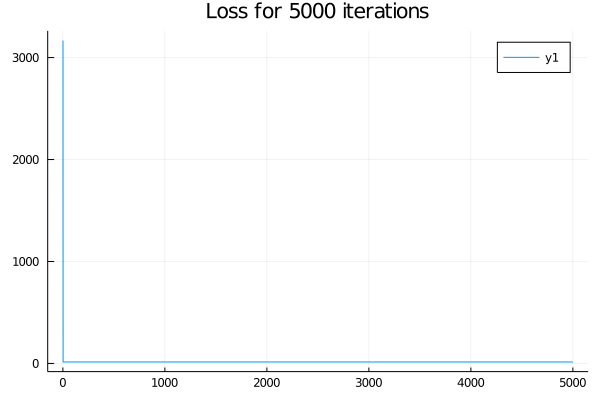

In [80]:
x_iter=1:length(lossvalues)
plot(x_iter, lossvalues, title="Loss for $(length(lossvalues)) iterations")

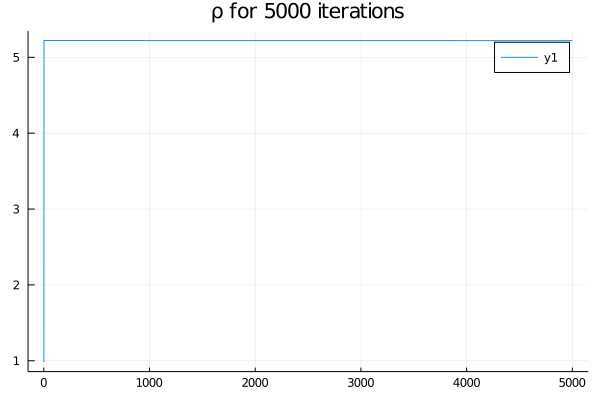

In [82]:
plot(x_iter, ρvalues, title="ρ for $(length(lossvalues)) iterations")

Interestingly, lambda did not change - we should be expecting it to move around

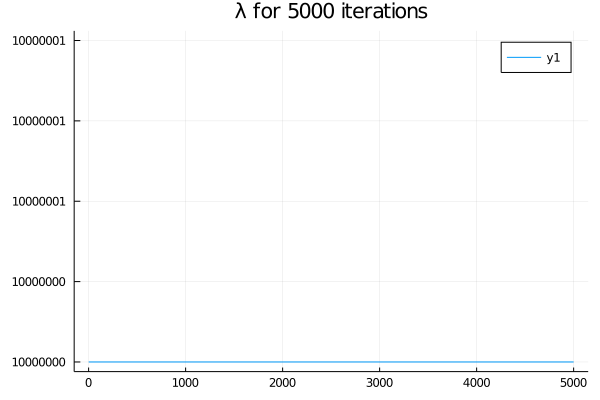

In [84]:
plot(x_iter, λvalues, title="λ for $(length(lossvalues)) iterations")

# Fitted parameters against the data, not great!

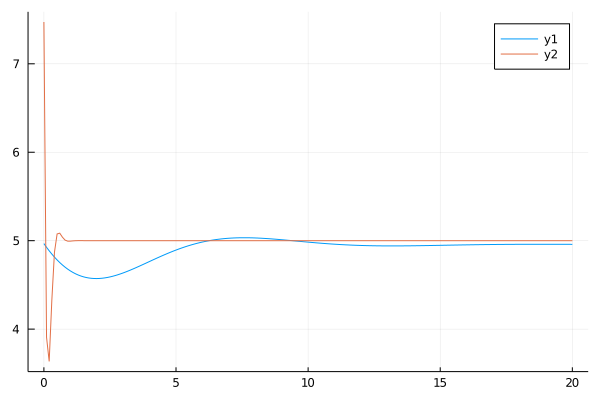

In [66]:
ŷ = f(x, newparameters...)
plot([x, x], [ŷ, y])

# Check function is "Type stable"

This macro expands into a list of the types Julia infers from the function, if they're all highlighted blue, then we're good!

In [67]:
@code_warntype step(f, collect(x), y, p)

Variables
  #self#::Core.Compiler.Const(step, false)
  f::Core.Compiler.Const(f, false)
  x::Array{Float64,1}
  y::Array{Float64,1}
  parameters::Array{Float64,1}
  #51::var"#51#53"

Body::Array{Float64,1}
1 ─      (#51 = %new(Main.:(var"#51#53")))
│   %2 = #51::Core.Compiler.Const(var"#51#53"(), false)
│   %3 = Base.vect()::Array{Any,1}
│   %4 = Base.vect()::Array{Any,1}
│   %5 = Base.vect()::Array{Any,1}
│   %6 = Main.:(var"#step#50")(0.01, %2, %3, %4, %5, #self#, f, x, y, parameters)::Array{Float64,1}
└──      return %6
